# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.experimental import AdamW
from typing import Tuple
from matplotlib import pyplot as plt

# Set seed for reproducibility.
tf.keras.utils.set_random_seed(42)

2023-02-24 14:33:34.019060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 14:33:34.683468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-24 14:33:34.683551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBR

In [2]:
print(tf.__version__)

2.11.0


In [3]:
# DATA
TRAIN_SLICE = 40000
BATCH_SIZE = 1024
BUFFER_SIZE = BATCH_SIZE*2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
IMAGE_SIZE = 48
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 25

# MODEL
PATCH_SIZE = 4
EMBED_DIM = 128
CHUNK_SIZE = 8
R = 2
NUM_LAYERS = 6
FFN_DROP = 0.1
ATTN_DROP = 0.1
NUM_HEADS = 1

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:TRAIN_SLICE], y_train[:TRAIN_SLICE]),
    (x_train[TRAIN_SLICE:], y_train[TRAIN_SLICE:]),
)

In [5]:
# Build the `train` augmentation pipeline.
train_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
        layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    ],
    name="test_data_augmentation",
)

2023-02-24 14:33:36.703677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 14:33:36.918334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38433 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [6]:
def train_map_fn(image, label):
    return train_aug(image), label

def test_map_fn(image, label):
    return test_aug(image), label

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds.map(
        train_map_fn, num_parallel_calls=AUTO
    )
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = (
    val_ds.map(
        test_map_fn, num_parallel_calls=AUTO
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds.map(
        test_map_fn, num_parallel_calls=AUTO
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [8]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)

(1024, 48, 48, 3)
(1024, 1)


# PatchEmbedding

In [9]:
class PatchEmbed(layers.Layer):
    """Image patch embedding layer.

    Args:
        image_size (`Tuple[int]`): Input image resolution.
        patch_size (`Tuple[int]`): Patch spatial resolution.
        embed_dim (`int`): Embedding dimension.
        chunk_size (`int`): Chunk size for the model.
    """

    def __init__(
        self,
        image_size: Tuple[int] = (48, 48),
        patch_size: Tuple[int] = (4, 4),
        embed_dim: int = 32,
        chunk_size: int = 8,
        **kwargs,
    ):
        super().__init__(**kwargs)
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]
        self.proj = layers.Conv2D(
            filters=embed_dim, kernel_size=patch_size, strides=patch_size
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=embed_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)
        self.norm = keras.layers.LayerNormalization(epsilon=1e-5)
        self.chunking_layer = layers.Reshape(
            target_shape=(self.num_patches//chunk_size, chunk_size, embed_dim)
        )

    def call(self, x: tf.Tensor):
        # Project the inputs.
        x = self.proj(x)
        x = self.flatten(x)
        x = x + self.position_embedding(self.positions)

        # B, H, W, C -> B, H*W, C
        x = self.norm(x)

        # Chunk the tokens in K
        x = self.chunking_layer(x)

        return x

# FFN

In [10]:
class FeedForwardNetwork(layers.Layer):
    """Feed Forward Network.

    Args:
        dims (`int`): Dimension of the FFN.
        dropout (`float`): Dropout probability of FFN.
    """

    def __init__(self, dims: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=4*dims, activation=tf.nn.gelu),
                layers.Dense(units=dims),
                layers.Dropout(rate=dropout),
            ]
        )
        self.add = layers.Add()
        self.layernorm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, inputs: tf.Tensor):
        x = self.layernorm(inputs)
        x = self.add([inputs, self.ffn(x)])
        return x

# Attention

In [11]:
class Attention(layers.Layer):
    """The base attention module.
    
    Args:
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        dropout (`float`): Dropout probability for Attention Module.
    
    """

    def __init__(self, num_heads: int, key_dim: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)
        self.q_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.k_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.v_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.add = layers.Add()

    def call(self, input_query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        query = self.q_layernorm(input_query)
        key = self.k_layernorm(key)
        value = self.v_layernorm(value)
        (attention_outs, attention_scores) = self.mha(
            query=query,
            key=key,
            value=value,
            return_attention_scores=True,
        )
        self.last_attention_scores = attention_scores
        x = self.add([input_query, attention_outs])
        return x

In [12]:
class AttentionWithFFN(layers.Layer):
    """Self-attention module with FFN

    Args:
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1, 
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.attention = Attention(num_heads, key_dim, attn_dropout)
        self.ffn = FeedForwardNetwork(ffn_dims, ffn_dropout)
        
    
    def call(self, query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        x = self.attention(query, key, value)
        x = self.ffn(x)
        return x

# Recurrence

In [13]:
class CustomCell(layers.Layer):
    """Custom logic inside each recurrence.

    Args:
        chunk_size (`int`): Chunk size of the inputs.
        r (`int`): One Cross Attention per **r** Self Attention.
        num_layers (`int`): Number of layers in the Perceptual Model.
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """
    def __init__(
        self,
        chunk_size,
        r=2,
        num_layers: int = 5,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1, 
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.chunk_size = chunk_size
        self.r = r
        self.num_layers = num_layers
        self.ffn_dims = ffn_dims
        self.ffn_droput = ffn_dropout
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

        self.state_size = tf.TensorShape([chunk_size, ffn_dims])
        self.output_size = tf.TensorShape([chunk_size, ffn_dims])

        ########################################################################
        # Perceptual Module
        ########################################################################
        perceptual_module = list()
        for layer_idx in range(num_layers):
            perceptual_module.append(
                AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout, 
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_SelfAttentionFFN{layer_idx}")
            )
            if layer_idx % r == 0:
                perceptual_module.append(
                    AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout, 
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_CrossAttentionFFN{layer_idx}")
                )
        self.perceptual_module = perceptual_module

        ########################################################################
        # Temporal Latent Bottleneck Module
        ########################################################################
        self.tlb_module = AttentionWithFFN(
            ffn_dims=ffn_dims,
            ffn_dropout=ffn_dropout, 
            num_heads=num_heads,
            key_dim=key_dim,
            attn_dropout=attn_dropout,
            name=f"TLBM_CrossAttentionFFN"
        )

    def call(self, inputs, states):
        # inputs => (batch, chunk_size, dims)
        # states => [(batch, chunk_size, units)]

        slow_stream = states[0]
        fast_stream = inputs

        for layer_idx, layer in enumerate(self.perceptual_module):
            fast_stream = layer(
                query=fast_stream,
                key=fast_stream,
                value=fast_stream
            )
            
            if layer_idx % self.r == 0:
                fast_stream = layer(
                    query=fast_stream,
                    key=slow_stream,
                    value=slow_stream
                )
        
        slow_stream = self.tlb_module(
            query=slow_stream,
            key=fast_stream,
            value=fast_stream
        )
        
        return fast_stream, [slow_stream]

In [14]:
keras.backend.clear_session()

inputs = keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3))

# PATCH
x = PatchEmbed(
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    patch_size=(PATCH_SIZE, PATCH_SIZE),
    embed_dim=EMBED_DIM,
    chunk_size=CHUNK_SIZE,
)(inputs)

# RECURRENCE
cell = CustomCell(
    chunk_size=CHUNK_SIZE,
    r=R,
    num_layers=NUM_LAYERS,
    ffn_dims=EMBED_DIM,
    ffn_dropout=FFN_DROP, 
    num_heads=NUM_HEADS,
    key_dim=EMBED_DIM,
    attn_dropout=ATTN_DROP,
)
x = layers.RNN(cell)(x)
x = tf.reduce_mean(x, axis=1)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.models.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 patch_embed (PatchEmbed)    (None, 18, 8, 128)        24960     
                                                                 
 rnn (RNN)                   (None, 8, 128)            1987840   
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 128)              0         
 mbda)                                                           
                                                                 
 dense_20 (Dense)            (None, 10)                1290      
                                                                 
Total params: 2,014,090
Trainable params: 2,014,090
Non-trainable params: 0
___________________________________________________

In [15]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

In [16]:
optimizer = AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and train the model.
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/25


2023-02-24 14:34:51.293679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-02-24 14:34:51.644033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-24 14:34:53.107279: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f1570033fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-24 14:34:53.107351: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-02-24 14:34:53.112195: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-24 14:34:53.233469: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

40/40 [==============================] - 160s 2s/step - loss: 3.6446 - accuracy: 0.1347 - val_loss: 2.8243 - val_accuracy: 0.1121
Epoch 2/25
40/40 [==============================] - 73s 2s/step - loss: 3.1113 - accuracy: 0.1660 - val_loss: 3.0543 - val_accuracy: 0.1624
Epoch 3/25
40/40 [==============================] - 72s 2s/step - loss: 2.1378 - accuracy: 0.2529 - val_loss: 1.9022 - val_accuracy: 0.3032
Epoch 4/25
40/40 [==============================] - 72s 2s/step - loss: 1.8392 - accuracy: 0.3281 - val_loss: 1.9270 - val_accuracy: 0.3088
Epoch 5/25
40/40 [==============================] - 72s 2s/step - loss: 1.7123 - accuracy: 0.3719 - val_loss: 1.6754 - val_accuracy: 0.3876
Epoch 6/25
40/40 [==============================] - 72s 2s/step - loss: 1.5937 - accuracy: 0.4150 - val_loss: 1.7093 - val_accuracy: 0.3890
Epoch 7/25
40/40 [==============================] - 72s 2s/step - loss: 1.5372 - accuracy: 0.4399 - val_loss: 1.4609 - val_accuracy: 0.4707
Epoch 8/25
40/40 [============

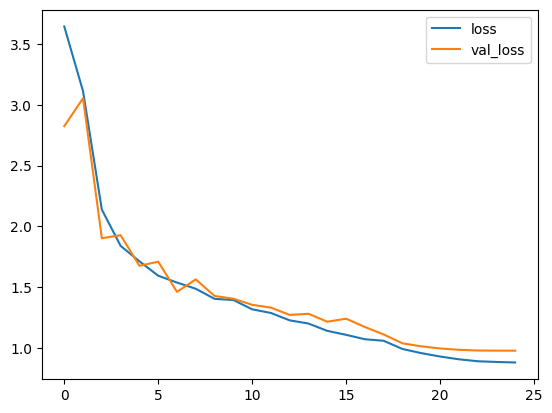

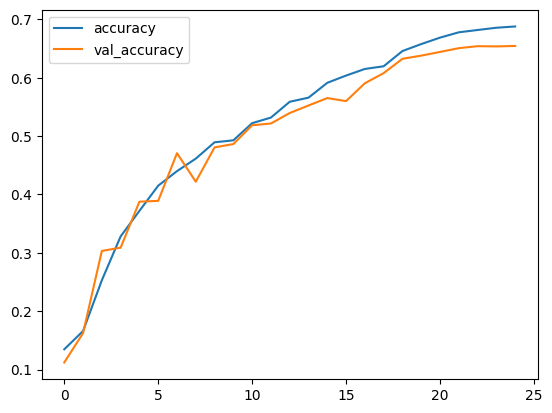

In [17]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()
 
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()